In [35]:
# ==============================================================================
# CÉLULA 1: Imports e Configurações Iniciais
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import joblib
import os
from datetime import datetime, timedelta

# Imports para Modelagem
import statsforecast # Para verificar a versão
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from tensorflow.keras.models import load_model

print(f"TensorFlow Version: {tf.__version__}")
print(f"StatsForecast Version: {statsforecast.__version__}")

# --- Configuração de Caminhos ---
output_directory = "./" 
os.makedirs(output_directory, exist_ok=True)
file_path_data_notebook = 'dados/preco_petroleo.csv' 
print(f"Usando arquivo de dados: {file_path_data_notebook}")
print(f"Arquivos de modelo serão salvos em: {os.path.abspath(output_directory)}")

TensorFlow Version: 2.19.0
StatsForecast Version: 2.0.1
Usando arquivo de dados: dados/preco_petroleo.csv
Arquivos de modelo serão salvos em: c:\Users\ReDragon\Desktop\TECH_CHALLENGE_FASE_4\STREAMLIT_APP


In [36]:
# ==============================================================================
# CÉLULA 2: Definição das Classes do Pipeline e Função de Erro
# ==============================================================================
class PrepareData(BaseEstimator, TransformerMixin):
    def __init__(self, date_col='Data', value_col='Value'):
        self.date_col = date_col
        self.value_col = value_col
    def fit(self, df, y=None): return self
    def transform(self, df):
        df_copy = df.copy()
        if 'Date' in df_copy.columns and self.date_col == 'Data': df_copy.rename(columns={'Date': 'Data'}, inplace=True)
        if 'Preço - petróleo bruto - Brent (FOB)' in df_copy.columns and self.value_col == 'Value': df_copy.rename(columns={'Preço - petróleo bruto - Brent (FOB)': 'Value'}, inplace=True)
        if self.date_col not in df_copy.columns: raise ValueError(f"Coluna de data '{self.date_col}' não encontrada.")
        if self.value_col not in df_copy.columns: raise ValueError(f"Coluna de valor '{self.value_col}' não encontrada.")
        df_copy[self.date_col] = pd.to_datetime(df_copy[self.date_col])
        df_copy.set_index(self.date_col, inplace=True); df_copy[self.value_col] = df_copy[self.value_col].astype(float)
        df_copy.dropna(subset=[self.value_col], inplace=True); df_copy.sort_index(inplace=True, ascending=True)
        return df_copy

class FillNANValues(BaseEstimator, TransformerMixin):
    def __init__(self, value_col='Value', new_value_col='y', new_date_col='ds'):
        self.value_col, self.new_value_col, self.new_date_col = value_col, new_value_col, new_date_col
    def fit(self, df, y=None): return self
    def transform(self, df):
        df_copy = df.copy()
        if not isinstance(df_copy.index, pd.DatetimeIndex): raise ValueError("DatetimeIndex esperado.")
        start_date, end_date = df_copy.index.min(), df_copy.index.max()
        if pd.isna(start_date) or pd.isna(end_date) or df_copy.empty: return pd.DataFrame(columns=[self.new_date_col, self.new_value_col])
        df_copy = df_copy.reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
        df_copy[self.value_col].ffill(inplace=True); df_copy[self.value_col].bfill(inplace=True)
        df_copy.dropna(subset=[self.value_col], inplace=True)
        if df_copy.empty: return pd.DataFrame(columns=[self.new_date_col, self.new_value_col])
        df_copy.reset_index(inplace=True)
        df_copy.rename(columns={'index': self.new_date_col, self.value_col: self.new_value_col}, inplace=True)
        return df_copy[[self.new_date_col, self.new_value_col]]

class SomthDataIntervalValues(BaseEstimator, TransformerMixin): 
    def __init__(self, value_col='y'): self.value_col = value_col
    def fit(self, df, y=None): return self
    def transform(self, df): 
        df_indexed = df.set_index('ds').copy()
        series_to_log = df_indexed[self.value_col].apply(lambda x: x if x > 0 else 1e-5)
        df_log = np.log(series_to_log)
        ma_log = df_log.rolling(window=7, min_periods=1).mean() 
        df_diff = (df_log - ma_log)
        df_transformed = pd.DataFrame(index=df_diff.index)
        df_transformed['y_diff_log'] = df_diff; df_transformed['y_ma_log'] = ma_log
        df_transformed.dropna(subset=['y_diff_log'], inplace=True); df_transformed.reset_index(inplace=True)
        return df_transformed
print("Classes de Pipeline definidas.")

calculos_erro_list_notebook = [] 
def calcula_erro_notebook(predicao, real, modelo_nome):
    global calculos_erro_list_notebook
    def symetric_mean_absolute_percentage_error(actual, predicted) -> float:
        actual, predicted = np.array(actual).flatten(), np.array(predicted).flatten()
        mask = ~ (np.isnan(actual) | np.isinf(actual) | np.isnan(predicted) | np.isinf(predicted))
        actual, predicted = actual[mask], predicted[mask]
        if len(actual) == 0: return np.nan
        denominator = (np.abs(predicted) + np.abs(actual)) / 2.0; diff = np.abs(predicted - actual)
        smape_values = np.where(denominator == 0, 0.0, diff / denominator)
        return round(np.mean(smape_values) * 100, 2)
    real_flat = np.array(real).flatten(); predicao_flat = np.array(predicao).flatten()
    min_len = min(len(real_flat), len(predicao_flat))
    if min_len == 0: retorno = {'modelo': modelo_nome, 'mae': np.nan, 'rmse': np.nan, 'smape %': np.nan}
    else:
        real_flat, predicao_flat = real_flat[:min_len], predicao_flat[:min_len]
        mae = mean_absolute_error(real_flat, predicao_flat); rmse = np.sqrt(mean_squared_error(real_flat, predicao_flat))
        smape = symetric_mean_absolute_percentage_error(real_flat, predicao_flat)
        retorno = {'modelo': modelo_nome, 'mae': round(mae,3), 'rmse': round(rmse,3), 'smape %': smape}
    calculos_erro_list_notebook.append(retorno)
    return retorno
print("Função calcula_erro_notebook definida.")

Classes de Pipeline definidas.
Função calcula_erro_notebook definida.


In [37]:
# ==============================================================================
# CÉLULA 3: Carregar Dados e Filtrar para Últimos 10 Anos
# ==============================================================================
try:
    df_brent_total_nb = pd.read_csv(file_path_data_notebook)
    if 'Date' in df_brent_total_nb.columns and 'Value' in df_brent_total_nb.columns:
        df_brent_total_nb.rename(columns={'Date': 'Data', 'Value': 'Value'}, inplace=True)
    elif not ('Data' in df_brent_total_nb.columns and 'Value' in df_brent_total_nb.columns):
        if len(df_brent_total_nb.columns) >= 2:
             df_brent_total_nb.rename(columns={df_brent_total_nb.columns[0]: 'Data', df_brent_total_nb.columns[1]: 'Value'}, inplace=True)
        else: raise ValueError("CSV não tem colunas 'Data' e 'Value'.")
    df_brent_total_nb['Data'] = pd.to_datetime(df_brent_total_nb['Data'])
    df_brent_total_nb.sort_values('Data', inplace=True, ignore_index=True)
except Exception as e:
    print(f"Erro Crítico ao carregar dados originais: {e}")
    raise

data_final_historico_nb = df_brent_total_nb['Data'].max()
data_inicio_10_anos_nb = data_final_historico_nb - pd.DateOffset(years=10)
df_brent_10anos_nb = df_brent_total_nb[df_brent_total_nb['Data'] >= data_inicio_10_anos_nb].copy()
print(f"Dados filtrados para os últimos 10 anos (a partir de {data_inicio_10_anos_nb.strftime('%d-%m-%Y')}). Formato: {df_brent_10anos_nb.shape}")
if df_brent_10anos_nb.empty: raise ValueError("DataFrame vazio após filtrar pelos últimos 10 anos.")


Dados filtrados para os últimos 10 anos (a partir de 04-11-2014). Formato: (2961, 2)


In [38]:
# ==============================================================================
# CÉLULA 4: Treinamento do Modelo ARIMAX (StatsForecast com Features Exógenas)
# ==============================================================================
print("\n--- Treinando Modelo AutoARIMAX (StatsForecast) para salvar (10 anos com features) ---")
pipeline_arima_transform_nb = Pipeline([
    ('data_prepator_arima', PrepareData(date_col='Data', value_col='Value')),
    ('filler_nan_values_arima', FillNANValues(value_col='Value', new_value_col='y', new_date_col='ds')),
    ('smoother_data_interval_arima', SomthDataIntervalValues(value_col='y'))
])
df_transformed_10a_for_arimax = pipeline_arima_transform_nb.fit_transform(df_brent_10anos_nb.copy())

# DataFrame que será passado para StatsForecast.fit()
# Deve conter 'unique_id', 'ds', 'y' (série alvo transformada) E as colunas de features exógenas escalonadas
df_fit_arimax_with_exog = df_transformed_10a_for_arimax[['ds', 'y_diff_log']].copy()
df_fit_arimax_with_exog.rename(columns={'y_diff_log': 'y'}, inplace=True)
df_fit_arimax_with_exog['unique_id'] = 'Brent'
df_fit_arimax_with_exog['ds'] = pd.to_datetime(df_fit_arimax_with_exog['ds'])

if df_fit_arimax_with_exog.empty:
    raise ValueError("DataFrame alvo para ARIMAX está vazio após transformações.")

# Criar features sazonais EXÓGENAS
df_exog_features_temp = df_fit_arimax_with_exog[['ds']].copy() 
df_exog_features_temp['dia_da_semana'] = df_exog_features_temp['ds'].dt.dayofweek
df_exog_features_temp['mes_sin'] = np.sin(2 * np.pi * df_exog_features_temp['ds'].dt.month / 12)
df_exog_features_temp['mes_cos'] = np.cos(2 * np.pi * df_exog_features_temp['ds'].dt.month / 12)
df_exog_features_temp['dia_do_ano_sin'] = np.sin(2 * np.pi * df_exog_features_temp['ds'].dt.dayofyear / 365.25)
df_exog_features_temp['dia_do_ano_cos'] = np.cos(2 * np.pi * df_exog_features_temp['ds'].dt.dayofyear / 365.25)
X_exog_arimax_unscaled_cols = ['dia_da_semana', 'mes_sin', 'mes_cos', 'dia_do_ano_sin', 'dia_do_ano_cos']
X_exog_arimax_unscaled_values = df_exog_features_temp[X_exog_arimax_unscaled_cols]

# Escalar features exógenas
scaler_exog_arimax_notebook = MinMaxScaler(feature_range=(0,1))
X_exog_arimax_scaled_values = scaler_exog_arimax_notebook.fit_transform(X_exog_arimax_unscaled_values)

# Adicionar features exógenas escalonadas ao df_fit_arimax_with_exog
# Os NOMES DAS COLUNAS DEVEM SER OS MESMOS que X_exog_arimax_unscaled_cols
for i, col_name in enumerate(X_exog_arimax_unscaled_cols):
    df_fit_arimax_with_exog[col_name] = X_exog_arimax_scaled_values[:, i]

# Salvar o scaler das features exógenas do ARIMAX
scaler_exog_arimax_path = os.path.join(output_directory, 'scaler_exog_arima.pkl')
joblib.dump(scaler_exog_arimax_notebook, scaler_exog_arimax_path)
print(f">>> Scaler para features exógenas do ARIMAX salvo como '{scaler_exog_arimax_path}' <<<")

# Treinar AutoARIMA com features exógenas
ARIMAX_SEASON_LENGTH = 30 
model_sf_arimax_to_save = StatsForecast(
    models=[AutoARIMA(season_length=ARIMAX_SEASON_LENGTH)], # SEM 'exogenous' aqui
    freq='D',
    n_jobs=-1
)
print(f"Ajustando AutoARIMAX com season_length={ARIMAX_SEASON_LENGTH}. As features exógenas estão no DataFrame de entrada.")
model_sf_arimax_to_save.fit(df_fit_arimax_with_exog) 
# ============================================================
print("AutoARIMAX (10 anos com features) ajustado.")

model_sf_arimax_path_to_save = os.path.join(output_directory, 'sarima_model_sf.pkl')
model_sf_arimax_to_save.save(model_sf_arimax_path_to_save)
print(f">>> Modelo AutoARIMAX (StatsForecast, 10 anos com features) salvo como '{model_sf_arimax_path_to_save}' <<<")


--- Treinando Modelo AutoARIMAX (StatsForecast) para salvar (10 anos com features) ---
>>> Scaler para features exógenas do ARIMAX salvo como './scaler_exog_arima.pkl' <<<
Ajustando AutoARIMAX com season_length=30. As features exógenas estão no DataFrame de entrada.


C:\Users\ReDragon\AppData\Local\Temp\ipykernel_21852\3994300265.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[self.value_col].ffill(inplace=True); df_copy[self.value_col].bfill(inplace=True)


AutoARIMAX (10 anos com features) ajustado.
Saving StatsForecast object of size 434.40KB.
StatsForecast object saved
>>> Modelo AutoARIMAX (StatsForecast, 10 anos com features) salvo como './sarima_model_sf.pkl' <<<


In [39]:
# ==============================================================================
# CÉLULA 5: Geração de Features ARIMAX para o LSTM Híbrido
# ==============================================================================
print("\n--- Gerando Features ARIMAX para LSTM Híbrido (baseado no modelo de 10 anos) ---")
h_for_arimax_features_insample = len(df_fit_arimax_with_exog) 

# Para prever com o modelo ARIMAX treinado, precisamos fornecer as features exógenas
# para o período da previsão. Neste caso, são as features históricas.
# O X_df para o predict do StatsForecast deve conter 'unique_id', 'ds' e as colunas exógenas.
X_df_for_predict_sf = df_fit_arimax_with_exog[['unique_id', 'ds'] + X_exog_arimax_unscaled_cols].copy()

predicted_arimax_transformed_features = model_sf_arimax_to_save.predict(
    h=h_for_arimax_features_insample, 
    X_df=X_df_for_predict_sf # Passa o DataFrame com as features exógenas históricas para o predict
)

# Reconstruir estas features ARIMAX para a escala original
ma_log_series_aligned = df_transformed_10a_for_arimax.set_index('ds').loc[df_fit_arimax_with_exog['ds']]['y_ma_log']
ma_log_relevant_arimax = ma_log_series_aligned.values

len_preds_arimax = 30
pred_col_name_arimax = 'AutoARIMA' 
if pred_col_name_arimax in predicted_arimax_transformed_features.columns:
    len_preds_arimax = len(predicted_arimax_transformed_features[pred_col_name_arimax])
    arimax_preds_values = predicted_arimax_transformed_features[pred_col_name_arimax].values
elif not predicted_arimax_transformed_features.empty:
    potential_pred_cols = [col for col in predicted_arimax_transformed_features.columns if col not in ['ds', 'unique_id']]
    if potential_pred_cols:
        pred_col_name_arimax = potential_pred_cols[0]
        arimax_preds_values = predicted_arimax_transformed_features[pred_col_name_arimax].values
        len_preds_arimax = len(arimax_preds_values)
        print(f"AVISO: Coluna 'AutoARIMA' não encontrada na previsão ARIMAX. Usando '{pred_col_name_arimax}'.")
    else: raise ValueError("Nenhuma coluna de previsão encontrada na saída do AutoARIMAX.")
else: raise ValueError("Previsão do AutoARIMAX resultou em DataFrame vazio.")

if len(ma_log_relevant_arimax) > len_preds_arimax:
    ma_log_relevant_arimax = ma_log_relevant_arimax[-len_preds_arimax:]
elif len(ma_log_relevant_arimax) < len_preds_arimax:
    ma_log_relevant_arimax = np.pad(ma_log_relevant_arimax, 
                                   (0, len_preds_arimax - len(ma_log_relevant_arimax)),
                                   'edge')
features_arimax_orig_scale_10a = np.exp(
    arimax_preds_values + ma_log_relevant_arimax
)
df_features_arimax_10a = pd.DataFrame({
    'ds': predicted_arimax_transformed_features['ds'], 
    'y_arimax_feature': features_arimax_orig_scale_10a
})
print(f"Features ARIMAX (10 anos) geradas e revertidas para escala original. Formato: {df_features_arimax_10a.shape}")


--- Gerando Features ARIMAX para LSTM Híbrido (baseado no modelo de 10 anos) ---
Features ARIMAX (10 anos) geradas e revertidas para escala original. Formato: (3654, 2)


In [40]:
# ==============================================================================
# CÉLULA 6: Preparação dos Dados Combinados e Engenharia de Features Sazonais para LSTM
# ==============================================================================
print("\n--- Preparando Dados Combinados e Features Sazonais para LSTM Híbrido (10 anos) ---")
pipeline_normalize_data_nb_10a = Pipeline([
    ('data_prepator', PrepareData(date_col='Data', value_col='Value')),
    ('filler_nan_values', FillNANValues(value_col='Value', new_value_col='y', new_date_col='ds'))])
df_normalized_hist_10a_for_lstm = pipeline_normalize_data_nb_10a.fit_transform(df_brent_10anos_nb.copy())
df_normalized_hist_10a_for_lstm['ds'] = pd.to_datetime(df_normalized_hist_10a_for_lstm['ds'])

df_combinado_para_lstm_pre_feat = df_normalized_hist_10a_for_lstm.merge(
    df_features_arimax_10a.rename(columns={'y_arimax_feature': 'y_arima_feature'}), on='ds', how='left'
)
df_combinado_para_lstm_pre_feat['y_final_lstm_input'] = df_combinado_para_lstm_pre_feat['y_arima_feature'].fillna(df_combinado_para_lstm_pre_feat['y'])
df_combinado_para_lstm_final = df_combinado_para_lstm_pre_feat[['ds', 'y_final_lstm_input']].rename(columns={'y_final_lstm_input': 'y'})

df_combinado_para_lstm_final['dia_da_semana'] = df_combinado_para_lstm_final['ds'].dt.dayofweek
df_combinado_para_lstm_final['mes_sin'] = np.sin(2 * np.pi * df_combinado_para_lstm_final['ds'].dt.month / 12)
df_combinado_para_lstm_final['mes_cos'] = np.cos(2 * np.pi * df_combinado_para_lstm_final['ds'].dt.month / 12)
df_combinado_para_lstm_final['dia_do_ano_sin'] = np.sin(2 * np.pi * df_combinado_para_lstm_final['ds'].dt.dayofyear / 365.25)
df_combinado_para_lstm_final['dia_do_ano_cos'] = np.cos(2 * np.pi * df_combinado_para_lstm_final['ds'].dt.dayofyear / 365.25)

features_lstm_cols = ['y', 'dia_da_semana', 'mes_sin', 'mes_cos', 'dia_do_ano_sin', 'dia_do_ano_cos']
df_para_scaler_lstm = df_combinado_para_lstm_final[features_lstm_cols].copy()
df_para_scaler_lstm.dropna(inplace=True) 
if df_para_scaler_lstm.empty: raise ValueError("DataFrame para scaler LSTM vazio.")
print(f"Dados combinados com features sazonais para LSTM. Formato: {df_para_scaler_lstm.shape}")


--- Preparando Dados Combinados e Features Sazonais para LSTM Híbrido (10 anos) ---
Dados combinados com features sazonais para LSTM. Formato: (3654, 6)


C:\Users\ReDragon\AppData\Local\Temp\ipykernel_21852\3994300265.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy[self.value_col].ffill(inplace=True); df_copy[self.value_col].bfill(inplace=True)



--- Treinamento do Modelo LSTM Híbrido (10 anos com Features Sazonais) ---
>>> Scaler LSTM (Híbrido com Features, 10 anos) salvo como './scaler.pkl' <<<
LSTM usará seq_length=90 e num_features=6
Formato de X_train_lstm_tuned (multivariado): (2852, 90, 6)

Iniciando treinamento do modelo LSTM híbrido com features sazonais (10 anos)...
Epoch 1/200


c:\Users\ReDragon\Desktop\TECH_CHALLENGE_FASE_4\STREAMLIT_APP\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 0.0686 - val_loss: 0.0038
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0056 - val_loss: 9.7713e-04
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0028 - val_loss: 8.6049e-04
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0024 - val_loss: 7.8341e-04
Epoch 7/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 9/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0020 - val_loss: 8.5546e-04
Epoch 10/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0018 - val_loss: 7.3937e-04
Epoch 11/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0019 - val_loss: 8.8121e-04
Epoch 12/200
36/36 ━━━━━━━━━━

Treinamento LSTM (10 anos com features) concluído.
>>> Modelo LSTM híbrido (10 anos com features) salvo como './lstm_model.h5' <<<


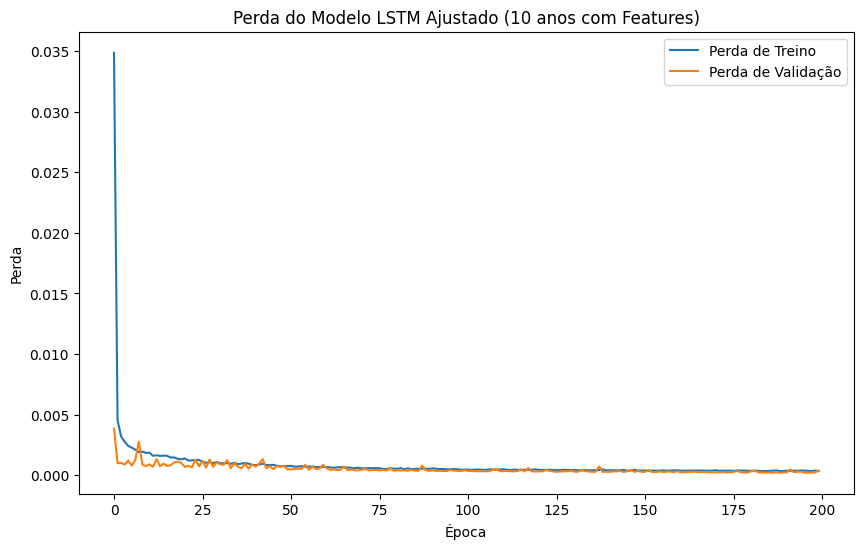

In [41]:
# ==============================================================================
# CÉLULA 7: Normalização, Criação de Sequências e Treinamento do LSTM Híbrido
# ==============================================================================

print("\n--- Treinamento do Modelo LSTM Híbrido (10 anos com Features Sazonais) ---")
scaler_lstm_hibrido_10a_tuned = MinMaxScaler(feature_range=(0, 1))
scaled_data_hibrido_lstm_10a_tuned = scaler_lstm_hibrido_10a_tuned.fit_transform(df_para_scaler_lstm) 
scaler_lstm_path_10a_tuned = os.path.join(output_directory, 'scaler.pkl')
joblib.dump(scaler_lstm_hibrido_10a_tuned, scaler_lstm_path_10a_tuned)
print(f">>> Scaler LSTM (Híbrido com Features, 10 anos) salvo como '{scaler_lstm_path_10a_tuned}' <<<")

seq_length_lstm_10a_tuned = 90 
num_features_lstm = scaled_data_hibrido_lstm_10a_tuned.shape[1]
print(f"LSTM usará seq_length={seq_length_lstm_10a_tuned} e num_features={num_features_lstm}")

def create_sequences_multivariate_notebook(data, seq_length):
    xs, ys = [], []
    if len(data) <= seq_length: return np.array(xs), np.array(ys)
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length), :]) 
        ys.append(data[i + seq_length, 0])    
    return np.array(xs), np.array(ys)

X_hibrido_lstm_10a_tuned, y_hibrido_lstm_10a_tuned = create_sequences_multivariate_notebook(
    scaled_data_hibrido_lstm_10a_tuned, seq_length_lstm_10a_tuned)
if X_hibrido_lstm_10a_tuned.shape[0] == 0: raise ValueError("Nenhuma sequência LSTM multivariada criada.")

tam_validacao_lstm_10a = int(len(X_hibrido_lstm_10a_tuned) * 0.2) 
if tam_validacao_lstm_10a < 1 and len(X_hibrido_lstm_10a_tuned) > 1: tam_validacao_lstm_10a = 1
elif len(X_hibrido_lstm_10a_tuned) <=1 : tam_validacao_lstm_10a = 0
if len(X_hibrido_lstm_10a_tuned) - tam_validacao_lstm_10a <= 0 and len(X_hibrido_lstm_10a_tuned) > 0 :
    tam_validacao_lstm_10a = 0 
    print("AVISO: Poucos dados para validação LSTM, treinando com todos os dados de sequência.")

X_train_lstm_10a_tuned, X_val_lstm_10a_tuned = X_hibrido_lstm_10a_tuned[:-tam_validacao_lstm_10a] if tam_validacao_lstm_10a > 0 else X_hibrido_lstm_10a_tuned, \
                                             X_hibrido_lstm_10a_tuned[-tam_validacao_lstm_10a:] if tam_validacao_lstm_10a > 0 else np.array([])
y_train_lstm_10a_tuned, y_val_lstm_10a_tuned = y_hibrido_lstm_10a_tuned[:-tam_validacao_lstm_10a] if tam_validacao_lstm_10a > 0 else y_hibrido_lstm_10a_tuned, \
                                             y_hibrido_lstm_10a_tuned[-tam_validacao_lstm_10a:] if tam_validacao_lstm_10a > 0 else np.array([])
print(f"Formato de X_train_lstm_tuned (multivariado): {X_train_lstm_10a_tuned.shape}")
if X_train_lstm_10a_tuned.shape[0] == 0: raise ValueError("X_train_lstm_10a_tuned está vazio.")

model_lstm_hibrido_10a_tuned = Sequential()
model_lstm_hibrido_10a_tuned.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length_lstm_10a_tuned, num_features_lstm)))
model_lstm_hibrido_10a_tuned.add(Dropout(0.3))
model_lstm_hibrido_10a_tuned.add(LSTM(units=128, return_sequences=False)) 
model_lstm_hibrido_10a_tuned.add(Dropout(0.3))
model_lstm_hibrido_10a_tuned.add(Dense(64, activation='relu')) 
model_lstm_hibrido_10a_tuned.add(Dense(1))
optimizer_10a_tuned = Adam(learning_rate=0.0005) 
model_lstm_hibrido_10a_tuned.compile(optimizer=optimizer_10a_tuned, loss='mean_squared_error')

print("\nIniciando treinamento do modelo LSTM híbrido com features sazonais (10 anos)...")
epochs_10a_tuned = 200 
batch_size_10a_tuned = 80 
early_stopping_10a = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
validation_data_lstm_10a = (X_val_lstm_10a_tuned, y_val_lstm_10a_tuned) if X_val_lstm_10a_tuned.shape[0] > 0 else None
history_lstm_10a_tuned = model_lstm_hibrido_10a_tuned.fit(
    X_train_lstm_10a_tuned, y_train_lstm_10a_tuned, epochs=epochs_10a_tuned, batch_size=batch_size_10a_tuned, 
    validation_data=validation_data_lstm_10a, callbacks=[early_stopping_10a] if validation_data_lstm_10a else [], verbose=1)
print("Treinamento LSTM (10 anos com features) concluído.")

model_lstm_h5_path_10a_tuned = os.path.join(output_directory, 'lstm_model.h5')
model_lstm_hibrido_10a_tuned.save(model_lstm_h5_path_10a_tuned)
print(f">>> Modelo LSTM híbrido (10 anos com features) salvo como '{model_lstm_h5_path_10a_tuned}' <<<")

if validation_data_lstm_10a and 'val_loss' in history_lstm_10a_tuned.history:
    plt.figure(figsize=(10,6))
    plt.plot(history_lstm_10a_tuned.history['loss'], label='Perda de Treino')
    if 'val_loss' in history_lstm_10a_tuned.history:
        plt.plot(history_lstm_10a_tuned.history['val_loss'], label='Perda de Validação')
    plt.title('Perda do Modelo LSTM Ajustado (10 anos com Features)')
    plt.xlabel('Época'); plt.ylabel('Perda'); plt.legend(); plt.show()

In [51]:
# ==============================================================================
# CÉLULA 8: Avaliação (Exemplo) e Salvamento de df_erros.csv
# ==============================================================================
calculos_erro_list_notebook = [] 
if validation_data_lstm_10a and X_val_lstm_10a_tuned.shape[0] > 0:
    pred_val_lstm_scaled_10a = model_lstm_hibrido_10a_tuned.predict(X_val_lstm_10a_tuned)
    dummy_array_for_inverse = np.zeros((len(pred_val_lstm_scaled_10a), num_features_lstm))
    dummy_array_for_inverse[:, 0] = pred_val_lstm_scaled_10a.flatten()
    pred_val_lstm_original_scale_10a = scaler_lstm_hibrido_10a_tuned.inverse_transform(dummy_array_for_inverse)[:, 0]
    dummy_array_for_inverse_y_true = np.zeros((len(y_val_lstm_10a_tuned), num_features_lstm))
    dummy_array_for_inverse_y_true[:, 0] = y_val_lstm_10a_tuned.flatten()
    y_val_original_scale_10a = scaler_lstm_hibrido_10a_tuned.inverse_transform(dummy_array_for_inverse_y_true)[:, 0]
    print("\nMétricas para LSTM Híbrido (10 anos com Features) no conjunto de validação:")
    print(calcula_erro_notebook(pred_val_lstm_original_scale_10a, y_val_original_scale_10a, "LSTM_Hibrido_ feats_10Anos_Val"))

df_erros_path_notebook = os.path.join(output_directory, 'df_erros.csv')
if calculos_erro_list_notebook:
    df_erros_final_notebook = pd.DataFrame(calculos_erro_list_notebook)
    df_erros_final_notebook.to_csv(df_erros_path_notebook, index=False)
    print(f">>> Métricas de erro salvas como '{df_erros_path_notebook}' <<<")
    print("\nDataFrame de Erros (do Notebook):\n", df_erros_final_notebook)
else:
    print(f"AVISO: 'calculos_erro_list_notebook' não populada. '{df_erros_path_notebook}' não foi criado.")

print("\n--- Processo de Geração de Artefatos (10 anos, ARIMAX e LSTM com features) Concluído ---")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Métricas para LSTM Híbrido (10 anos com Features) no conjunto de validação:
{'modelo': 'LSTM_Hibrido_ feats_10Anos_Val', 'mae': 1.285, 'rmse': np.float64(1.734), 'smape %': np.float64(1.58)}
>>> Métricas de erro salvas como './df_erros.csv' <<<

DataFrame de Erros (do Notebook):
                            modelo    mae   rmse  smape %
0  LSTM_Hibrido_ feats_10Anos_Val  1.285  1.734     1.58

--- Processo de Geração de Artefatos (10 anos, ARIMAX e LSTM com features) Concluído ---
